In [1]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [7]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [30]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [48]:
import uuid

In [50]:
# menghubungkan wbcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    # potong frame agar 250x250px
    frame = frame[160:160+250,200:200+250, :]
    # Menampilkan gambar di layar
    cv2.imshow('Kamera', frame)
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    # Menghentikan kerja kamera
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
# release webcam
cap.release()
# Close img show window
cv2.destroyAllWindows()

In [8]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [9]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (105, 105))
    img /= 255.0
    return img

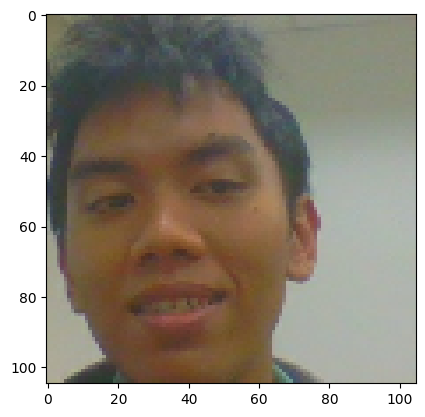

In [10]:
img = preprocess('data\\anchor\\c0ae5c54-abcb-11ef-9c25-bd11ab0e6bf0.jpg')
plt.imshow(img)

In [11]:
positif = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))) # positif as 1
negatif = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))))) # negatif as 0
data = positif.concatenate(negatif)

In [12]:
samples = data.as_numpy_iterator()

In [13]:
samples.next()

(b'data\\anchor\\bf2c3b98-abcb-11ef-a9d6-bd11ab0e6bf0.jpg',
 b'data\\positive\\c594c9e8-abcb-11ef-b3f2-bd11ab0e6bf0.jpg',
 1.0)

bagi train dan test

In [14]:
def preprocess2(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [15]:
# build dataloader pipeline
data = data.map(preprocess2)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [16]:
train_data = data.take(int(round(len(data))*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [17]:
test_data = data.skip(int(round(len(data))*.7))
test_data = data.take(int(round(len(data))*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

Model embedding

In [18]:
input = Input(shape=(105,105,3), name = 'input_image')

In [19]:
c1 = Conv2D(64, (10,10), activation='relu')(input)

In [20]:
m1 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(c1)

In [21]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(c2)

In [22]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(c3)

In [23]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [24]:
model = Model(inputs=input, outputs=d1, name='embedding')

In [25]:
model.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 105, 105, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 42, 42, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
def model_embed():
    input = Input(shape=(105,105,3), name = 'input_image')
    c1 = Conv2D(64, (10,10), activation='relu')(input)
    m1 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(c1)
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(c2)
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(c3)
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    return Model(inputs=input, outputs=d1, name='embedding')

In [27]:
embed_model = model_embed()

layer distance

In [28]:
class LDist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

Siamese Model

In [29]:
input_img = Input(name='input_img', shape=(105,105,3))
val_img = Input(name='val_img', shape=(105,105,3))

In [30]:
inp_embed = embed_model(input_img)
val_embed = embed_model(val_img)

In [31]:
siamese = LDist()

In [32]:
dist = siamese(inp_embed, val_embed)

In [33]:
classification = Dense(1, activation='sigmoid')(dist)

In [34]:
siamese_nn = Model(inputs=[input_img, val_img], outputs=classification, name='Siamese_Network')

In [35]:
siamese_nn.summary()

Model: "Siamese_Network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ val_img             │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ val_img[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_dist (LDist)      │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l_dist[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
binaryCross = tf.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(1e-5)

In [37]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_nn(X, training=True)
        # Calculate loss
        loss = binaryCross(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_nn.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    optimizer.apply_gradients(zip(grad, siamese_nn.trainable_variables))
        
    # Return loss
    return loss

In [38]:
def train(data, epochs):
    for epoch in range(1, epochs+1):
        print('\n Epoch {}/{}'.format(epoch, epochs))
        Progres = tf.keras.utils.Progbar(len(data))
        r = tf.keras.metrics.Recall()
        p = tf.keras.metrics.Precision()

        for index, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_nn.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            Progres.update(index+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy)

In [39]:
train(train_data,50)


 Epoch 1/50


Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
8/9 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/stepTensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step
0.67732847 0.11764706 <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=1.0>>

 Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s

evaluate model

In [40]:
# ambil batch test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [41]:
y_hat = siamese_nn.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


In [42]:
r = tf.keras.metrics.Recall()
p = tf.keras.metrics.Precision()
for test_input, test_val, y_true in test_data.as_numpy_iterator():
    y_hat = siamese_nn.predict([test_input, test_val])
    r.update_state(y_true, y_hat)
    p.update_state(y_true, y_hat)
print(r.result().numpy(), p.result().numpy(),)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1.0 1.0


In [43]:
train(train_data, 50)


 Epoch 1/50


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step
0.013832001 1.0 <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=1.0>>

 Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
0.0003379836 1.0 <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=1.0>>


In [44]:
test_input, test_data, y_true = test_data.as_numpy_iterator().next()